# SkimLit

The purpose of this notebook is to build an NLP model to make medical abstracts (and maybe other abstracts ?) easier to read.

We're going to replicate this paper : https://arxiv.org/abs/1710.06071

The model architecture they used to achieve their best results is here: https://arxiv.org/abs/1612.05251

### Check access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-2e681fd0-726c-06e4-da29-97ce9066c168)


## Data

### Get data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [ ]:
!unzip /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip -d /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign
!rm /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip 
!rm -rf /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/.ipynb_checkpoints
!ls /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt  
dev.txt  test.txt  train.txt


In [ ]:
import os

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preprocess data

The files are formatted in this way :

<br>

**[TYPE OF SENTENCE] &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [SENTENCE]**

<br>

We have to preprocess it in order to be able to work with it.

In [ ]:
with open(filenames[0],"r") as f:
  lines = f.readlines()[:15]
  for line in lines:
    print(repr(line)) # helps us to see encoded stuff like \n

'###24845963\n'
'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n'
'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n'
'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n'
'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n'
"RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n"
'RESULTS\tWhen m

<br>

We can see there is a **\t** in each sentence separating the type of sentence from the sentence. We could split the sentence with this character to get two lists (sentences and labels, or X and y) and ignore any line without a **\t**.

<br>

In [ ]:
import pandas as pd

def preprocess(filename):
  with open(filename,"r") as f:
    input_lines = f.readlines()
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
train_data = pd.DataFrame(preprocess(filenames[2]))
test_data = pd.DataFrame(preprocess(filenames[0]))
val_data = pd.DataFrame(preprocess(filenames[1]))
train_data[:10]

,target,text,line,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


### EDA

In [ ]:
len(test_data), len(train_data), len(val_data)

(30135, 180040, 30212)

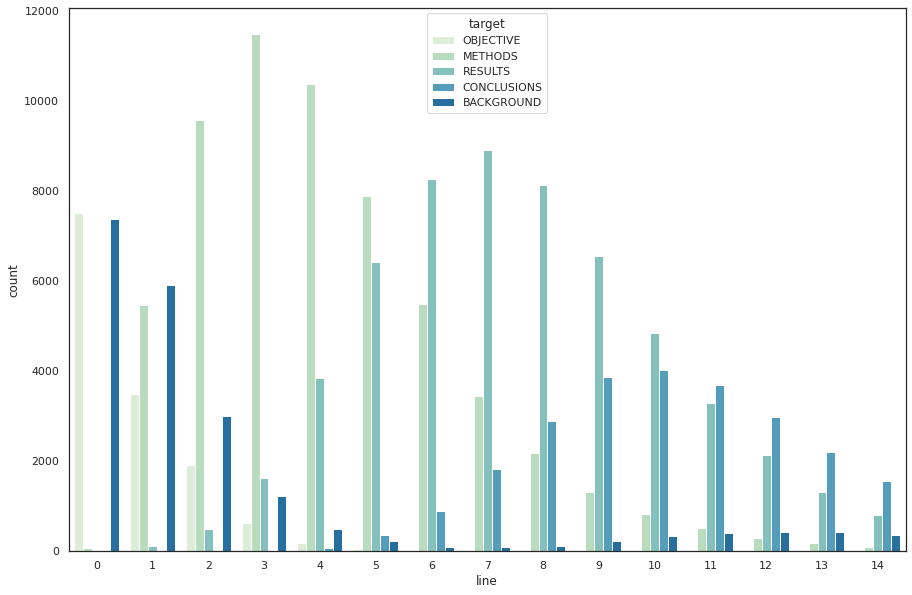

In [ ]:
# Distribution of types depending on sentence number
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(
    style="white", 
    palette="muted", 
    color_codes=True
)
plt.figure(figsize=(15,10))
sns.countplot(
          data=train_data,
          x="line",
          hue="target",
          palette= "GnBu"
          ,
          order=train_data["line"].value_counts().iloc[:15].index);

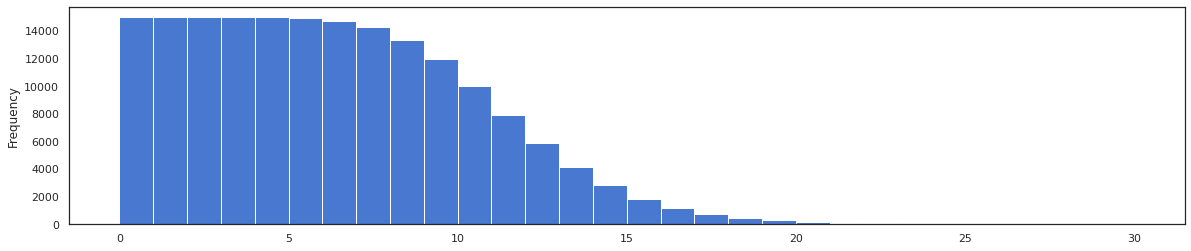

In [ ]:
# Distribution of sentence number

plt.figure(figsize=(20,4))
train_data["line"].plot.hist(bins=30);

### Turn labels into numeric form

In [ ]:
### One Hot Encoded
from sklearn.preprocessing import OneHotEncoder

oh = OneHotEncoder(sparse=False)
train_labels_oh = oh.fit_transform(train_data["target"].to_numpy().reshape(-1, 1))
test_labels_oh = oh.transform(test_data["target"].to_numpy().reshape(-1, 1))
val_labels_oh = oh.transform(val_data["target"].to_numpy().reshape(-1, 1))

In [ ]:
pd.DataFrame(train_labels_oh)

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
180035,0.0,0.0,0.0,0.0,1.0
180036,0.0,0.0,0.0,0.0,1.0
180037,0.0,0.0,0.0,0.0,1.0
180038,0.0,1.0,0.0,0.0,0.0


In [ ]:
### Label encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels_le = le.fit_transform(train_data["target"])
test_labels_le = le.transform(test_data["target"])
val_labels_le = le.transform(val_data["target"])

In [ ]:
pd.DataFrame(train_labels_le)

,0
0,3
1,2
2,2
3,2
4,2
...,...
180035,4
180036,4
180037,4
180038,1


In [ ]:
num_classes = len(le.classes_)
class_names = le.classes_
num_classes , class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling

### Model 0 : Baseline (Naive Bayes with TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tf-idf",TfidfVectorizer()),
                    ("clf",MultinomialNB())
])

model_0.fit(train_data["text"],train_labels_le)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
from sklearn.metrics import classification_report
report_0 = classification_report(val_labels_le,model_0.predict(val_data["text"]),target_names=class_names)
print(report_0,model_0.score(val_data["text"],val_labels_le))

              precision    recall  f1-score   support

  BACKGROUND       0.66      0.49      0.56      3449
 CONCLUSIONS       0.65      0.59      0.61      4582
     METHODS       0.72      0.87      0.79      9964
   OBJECTIVE       0.75      0.14      0.23      2376
     RESULTS       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212
 0.7218323844829869


### Preparing data for deep sequences model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# average sentence lenght
sent_lens = [len(sentence.split()) for sentence in train_data["text"]]
av_sent_lens = np.mean(sent_lens)
av_sent_lens

26.338269273494777

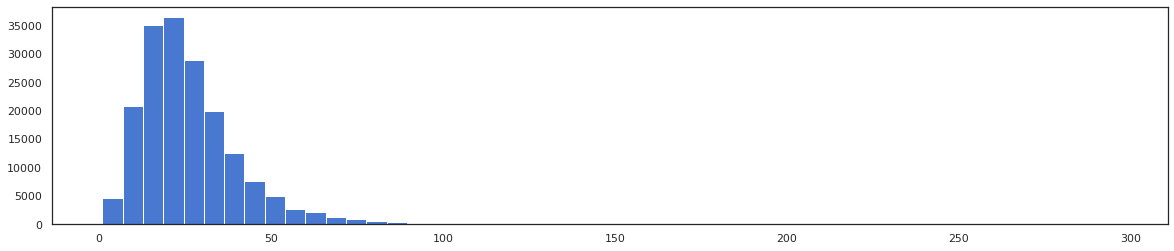

In [ ]:
# distribution of number of words
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.hist(sent_lens, bins = 50);

In [ ]:
# what max lenght to cover 95% of our data ?
pred_max_len = int(np.percentile(sent_lens,95))
pred_max_len

55

In [ ]:
max(sent_lens)

296

### Create text vectorizer layer

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68_000 # There is 68k different words in our vocabulary according to the original paper https://arxiv.org/pdf/1710.06071.pdf

text_vec = TextVectorization(max_tokens=max_tokens,
                             output_sequence_length=pred_max_len)

In [ ]:
#  Adapt text vectorizer to training sentences
text_vec.adapt(train_data["text"])

In [ ]:
# Test it
import random
target = random.choice(train_data["text"])
print(f"""
Text:\n{target}

-----------------

Lenght:\n{len(target.split())}

-----------------

Vectorized:\n{text_vec([target])}""")


Text:
we observed significantly less bcf and lf in the high-dose arm .

-----------------

Lenght:
12

-----------------

Vectorized:
[[   43   148    39   211 32479     3  4196     5     2  1350   207     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many different words
rct_20k_vocab = text_vec.get_vocabulary()
print(f"Number : {len(rct_20k_vocab)}")
print(f"Most common : {rct_20k_vocab[:5]}")
print(f"least common : {rct_20k_vocab[-5:]}")

Number : 64841
Most common : ['', '[UNK]', 'the', 'and', 'of']
least common : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vec.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [ ]:
token_emb = layers.Embedding(input_dim=len(train_data["text"]),
                             output_dim=128,
                             mask_zero=True,
                             name="token_embedding")

In [ ]:
target = random.choice(train_data["text"])
vec_sent = text_vec([target])
emb_sent = token_emb(vec_sent)

print(f"""
Text:\n{target}

-----------------

Vec:\n{vec_sent}

-----------------

Emb:\n{emb_sent}""")


Text:
to test the hypothesis that the impact on cardiac structure and function after intramyocardial injections of autologous mscs results from a concordance of prorecovery phenotypic effects .

-----------------

Vec:
[[    6   128     2   930    28     2   305    18   342  2743     3   149
     21 10305   831     4  2598  6628   117    27     8  4665     4 35245
   9094    71     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

-----------------

Emb:
[[[-0.01146288 -0.00919499  0.0090454  ... -0.00566579  0.02574965
   -0.02714073]
  [-0.03566134  0.00471165 -0.00732742 ... -0.00609612 -0.00495911
   -0.00960689]
  [-0.03254475 -0.00353479  0.01369439 ...  0.00241952 -0.03542222
   -0.01566119]
  ...
  [ 0.0045297  -0.02141566  0.01649321 ... -0.0041483  -0.02171525
    0.01167712]
  [ 0.0045297  -0.02141566  0.01649321 ... -0.0041483  -0.02171525
    0.01

### Create datasets ( to load data as fast as possible )

In [ ]:
# Turn our data into Tensorflow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_data["text"],train_labels_oh))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data["text"],val_labels_oh))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data["text"],test_labels_oh))
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Turn data into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1:Conv1D with token embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vector = text_vec(inputs)
text_emb = token_emb(text_vector)
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(text_emb)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)

model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
hist_model1 = model_1.fit(train_dataset,
                          validation_data = val_dataset,
                          steps_per_epoch= int(0.1*len(train_dataset)),
                          epochs=3,
                          validation_steps= int(0.10 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 47s 26ms/step - loss: 0.9287 - accuracy: 0.6340 - val_loss: 0.6900 - val_accuracy: 0.7311
Epoch 2/3
562/562 [==============================] - 14s 26ms/step - loss: 0.6580 - accuracy: 0.7571 - val_loss: 0.6348 - val_accuracy: 0.7676
Epoch 3/3
562/562 [==============================] - 14s 26ms/step - loss: 0.6151 - accuracy: 0.7759 - val_loss: 0.5873 - val_accuracy: 0.7852


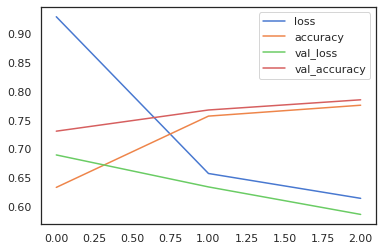

In [ ]:
pd.DataFrame(hist_model1.history).plot();

In [ ]:
model_1.evaluate(val_dataset)

942/942 [==============================] - 5s 5ms/step - loss: 0.6096 - accuracy: 0.7835


[0.6096189022064209, 0.7834743857383728]

### Model 2 : Feature Extractor with pretrained token embedding

In [ ]:
import tensorflow_hub as hub

hub_emb_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                               trainable=False)

In [ ]:
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding =hub_emb_layer(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs)

Epoch 1/5
844/844 [==============================] - 21s 21ms/step - loss: 0.8705 - accuracy: 0.6644 - val_loss: 0.7826 - val_accuracy: 0.6986
Epoch 2/5
844/844 [==============================] - 18s 21ms/step - loss: 0.7544 - accuracy: 0.7112 - val_loss: 0.7487 - val_accuracy: 0.7077
Epoch 3/5
844/844 [==============================] - 18s 21ms/step - loss: 0.7195 - accuracy: 0.7241 - val_loss: 0.7123 - val_accuracy: 0.7221
Epoch 4/5
844/844 [==============================] - 18s 21ms/step - loss: 0.7199 - accuracy: 0.7236 - val_loss: 0.6904 - val_accuracy: 0.7327
Epoch 5/5
844/844 [==============================] - 18s 22ms/step - loss: 0.6806 - accuracy: 0.7415 - val_loss: 0.6777 - val_accuracy: 0.7378


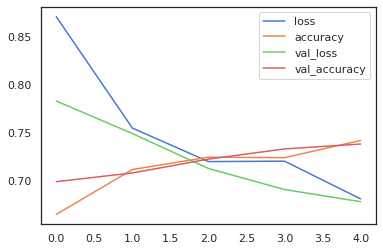

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_2_hist = model_2.fit(train_dataset,
            epochs=5,
            steps_per_epoch=int(0.15 * len(train_dataset)),
            validation_data=val_dataset,
            validation_steps=int(0.15 * len(val_dataset)))

pd.DataFrame(model_2_hist.history).plot()

In [ ]:
report2 = model_2.evaluate(val_dataset)
report2

942/942 [==============================] - 17s 18ms/step - loss: 0.6884 - accuracy: 0.7380


[0.6883915066719055, 0.7380122542381287]

In [ ]:
class_names[tf.argmax(model_2.predict(["In order to get this done, we have to make some experiments"])[0])]

'METHODS'

In [ ]:
class_names[tf.argmax(model_2.predict(["The figures show the relationship between this and that"])[0])]

'RESULTS'

### Model 3 : Conv1D with character embeddings

In [ ]:
# we're goin to create a character-level tokenizer
def split_char(text):
  return " ".join(list(text))

In [ ]:
train_chars = [split_char(sentence) for sentence in train_data["text"]]
val_chars = [split_char(sentence) for sentence in val_data["text"]]
test_chars = [split_char(sentence) for sentence in test_data["text"]]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Average length ?

chars_lens = [len(sentence) for sentence in train_data["text"]]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

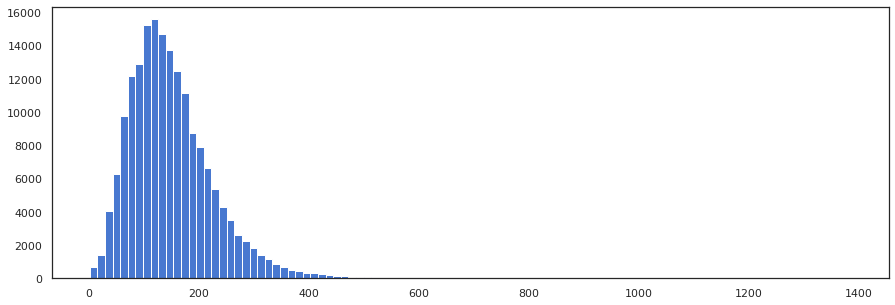

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(chars_lens,bins=100);

In [ ]:
out_char_len = int(np.percentile(chars_lens,95))
out_char_len

290

In [ ]:
# get all characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer

char_vectorizer = TextVectorization(max_tokens=len(alphabet)+2,
                                    output_sequence_length = out_char_len,
                                    )

In [ ]:
# Adapt it to our data
char_vectorizer.adapt(train_chars)

In [ ]:
char_vectorizer.get_vocabulary() # The most to the least used character

['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q',
 'j']

In [ ]:
# Create a char embedding layer

char_emb = layers.Embedding(input_dim=len(char_vectorizer.get_vocabulary()),
                            output_dim=25, # size of the char embedding from the paper
                            mask_zero=True)

In [ ]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
char_vec = char_vectorizer(inputs)
char_em = char_emb(char_vec)
x = layers.Conv1D(64,kernel_size=10,padding="same",activation="relu")(char_em)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs,outputs)
model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics="accuracy")

In [ ]:
char_train_data = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
char_val_data = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
char_test_data = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)

Epoch 1/8
562/562 [==============================] - 7s 12ms/step - loss: 1.2338 - accuracy: 0.4947 - val_loss: 1.0216 - val_accuracy: 0.5971
Epoch 2/8
562/562 [==============================] - 6s 11ms/step - loss: 0.9641 - accuracy: 0.6197 - val_loss: 0.8963 - val_accuracy: 0.6529
Epoch 3/8
562/562 [==============================] - 6s 11ms/step - loss: 0.8684 - accuracy: 0.6666 - val_loss: 0.8163 - val_accuracy: 0.6932
Epoch 4/8
562/562 [==============================] - 6s 11ms/step - loss: 0.8148 - accuracy: 0.6874 - val_loss: 0.7831 - val_accuracy: 0.7064
Epoch 5/8
562/562 [==============================] - 6s 11ms/step - loss: 0.7956 - accuracy: 0.6929 - val_loss: 0.7631 - val_accuracy: 0.7128
Epoch 6/8
562/562 [==============================] - 6s 11ms/step - loss: 0.7805 - accuracy: 0.7003 - val_loss: 0.7390 - val_accuracy: 0.7214
Epoch 7/8
562/562 [==============================] - 6s 11ms/step - loss: 0.7617 - accuracy: 0.7064 - val_loss: 0.7332 - val_accuracy: 0.7284
Epoch 

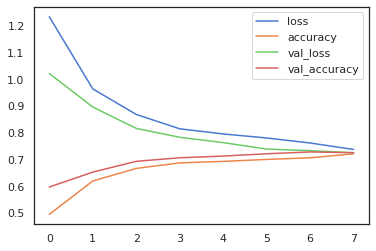

In [ ]:
model3_hist = model_3.fit(char_train_data,
                         epochs=8,
                         steps_per_epoch=int(0.1 * len(char_train_data)),
                         validation_data=char_val_data,
                         validation_steps=int(0.1 * len(char_val_data)))

model_3.evaluate(char_val_data)
pd.DataFrame(model3_hist.history).plot();

### Model 4 : Character embedding + token embedding

In [ ]:
# Setup token model
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_input")
token_emb = hub_emb_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_emb)
token_model = tf.keras.Model(token_inputs,token_outputs)

In [ ]:
# Setup char model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vec = char_vectorizer(char_inputs)
char_em = char_emb(char_vec)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_em)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

In [ ]:
# Concatenate
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

In [ ]:
# Create output layers - adding in Dropout

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
combined_dropout = layers.Dropout(0.5)(combined_dense)
output = layers.Dense(num_classes,activation="softmax")(combined_dropout)

In [ ]:
# Construct model with both inputs

model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output)

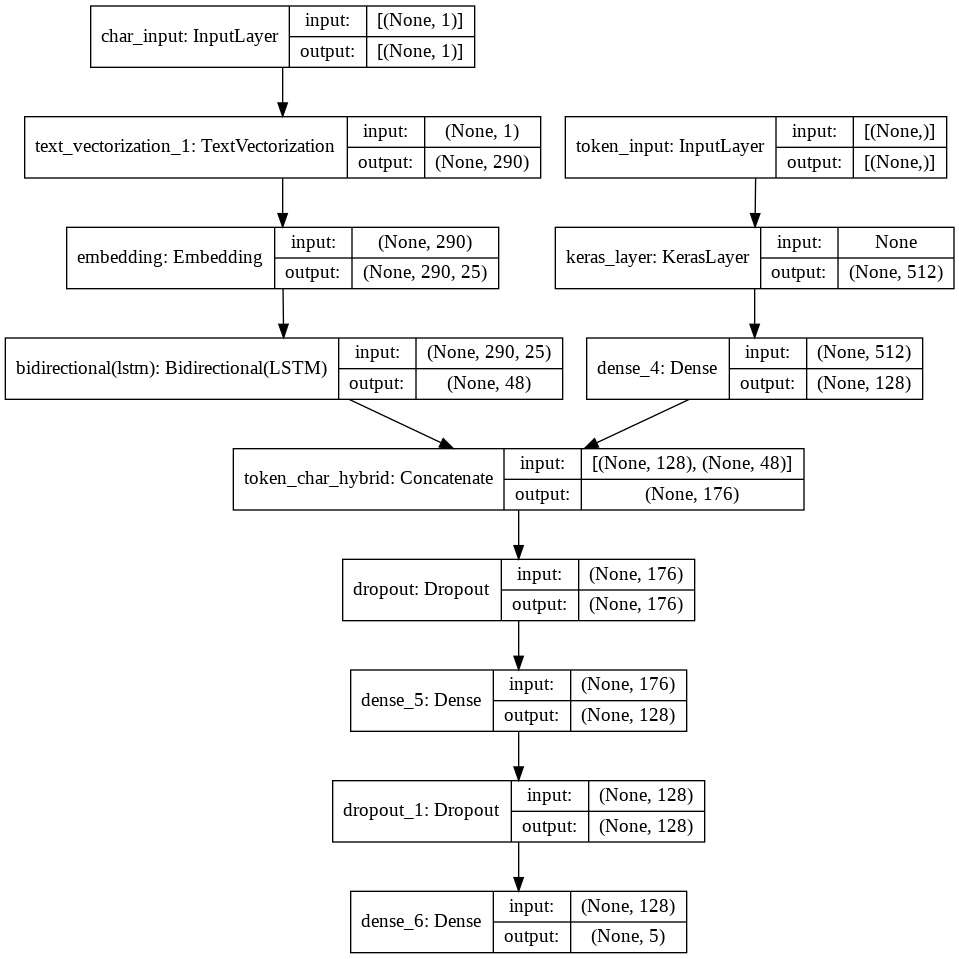

In [ ]:
# plot model
tf.keras.utils.plot_model(model_4,show_shapes=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics="accuracy")

In [ ]:
# Combine token and char into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_data["text"],train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data,train_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_data["text"],val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data,val_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_token_char_data = tf.data.Dataset.from_tensor_slices((test_data["text"],test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_oh)
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data,test_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model4_hist = model_4.fit(train_token_char_dataset,
                          epochs=5,
                          steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                          validation_data=val_token_char_dataset,
                          validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/5
562/562 [==============================] - 87s 136ms/step - loss: 0.9857 - accuracy: 0.6064 - val_loss: 0.7871 - val_accuracy: 0.6988
Epoch 2/5
562/562 [==============================] - 73s 130ms/step - loss: 0.7943 - accuracy: 0.6913 - val_loss: 0.7131 - val_accuracy: 0.7307
Epoch 3/5
562/562 [==============================] - 69s 123ms/step - loss: 0.7708 - accuracy: 0.7012 - val_loss: 0.6861 - val_accuracy: 0.7424
Epoch 4/5
562/562 [==============================] - 75s 133ms/step - loss: 0.7456 - accuracy: 0.7185 - val_loss: 0.6646 - val_accuracy: 0.7533
Epoch 5/5
562/562 [==============================] - 71s 127ms/step - loss: 0.7463 - accuracy: 0.7180 - val_loss: 0.6525 - val_accuracy: 0.7503


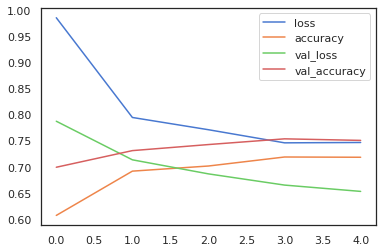

In [ ]:
pd.DataFrame(model4_hist.history).plot();

In [ ]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 51s 54ms/step - loss: 0.6632 - accuracy: 0.7460


[0.6631547212600708, 0.7460280656814575]

### Model 5 : Character embedding + token embedding + positional embedding

( a conclusion is more likely to be at the end whereas a background is more often a the beginning )

In [ ]:
# Create positional embeddings

# One-hot-encode line_number
train_line_number_oh = tf.one_hot(train_data["line"],depth=20)
test_line_number_oh = tf.one_hot(test_data["line"],depth=20)
val_line_number_oh = tf.one_hot(val_data["line"],depth=20)
train_line_number_oh[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

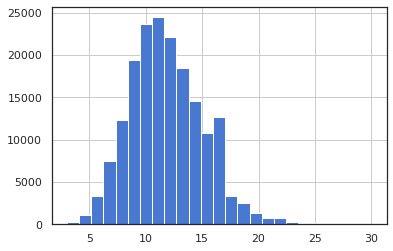

In [ ]:
# One-hot total_line

train_data["total_lines"].hist(bins=25);

In [ ]:
train_line_total_oh = tf.one_hot(train_data["total_lines"],depth=20)
test_line_total_oh = tf.one_hot(test_data["total_lines"],depth=20)
val_line_total_oh = tf.one_hot(val_data["total_lines"],depth=20)
train_line_total_oh[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Build a thribrid model

# Token model
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_inputs")
token_emb = hub_emb_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_emb)
token_model = tf.keras.Model(token_inputs,token_outputs)

# Char model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vec = char_vectorizer(char_inputs)
char_em = char_emb(char_vec)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_em)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

# Concatenate
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
z = layers.Dense(256,activation="relu")(token_char_concat)
z = layers.Dropout(0.5)(z)

# Line number model
line_number_inputs = layers.Input(shape=(20,),dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,x)

# Total line model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32, name="total_line_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,y)

# Concatenate
tribrid_emb = layers.Concatenate(name="tribrid_emb")([z,
                                                      line_number_model.output,
                                                      total_lines_model.output])

# Output layers
a = layers.Dense(128,activation="relu")(tribrid_emb)
a = layers.Dropout(0.5)(a)
output_layer = layers.Dense(5,activation="softmax",name="output_layer")(a)

model_5 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_number_model.input,
                                 total_lines_model.input],
                         outputs=output_layer)

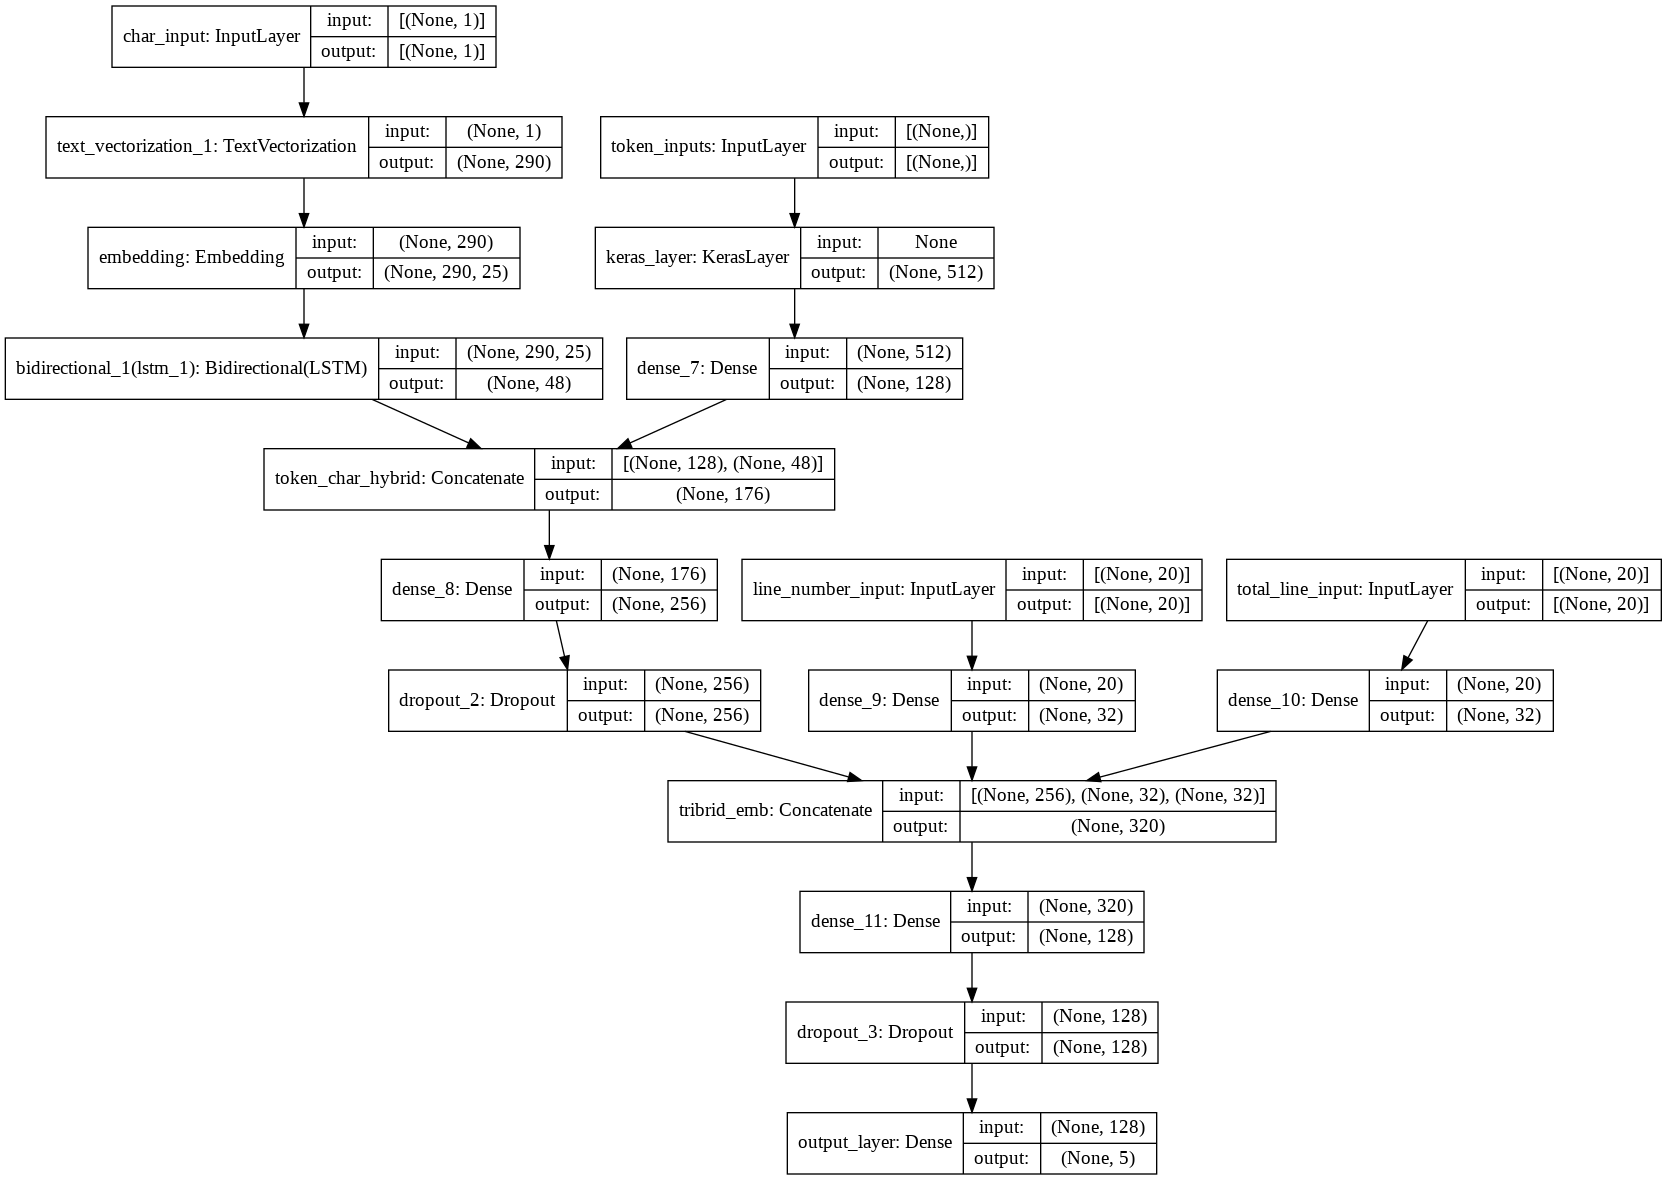

In [ ]:
tf.keras.utils.plot_model(model_5,show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="Adam",
                metrics="accuracy")

In [ ]:
train_all_data = tf.data.Dataset.from_tensor_slices((train_data["text"],train_chars,train_line_number_oh,train_line_total_oh))
train_all_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh)
train_all_dataset = tf.data.Dataset.zip((train_all_data,train_all_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_all_data = tf.data.Dataset.from_tensor_slices((val_data["text"],val_chars,val_line_number_oh,val_line_total_oh))
val_all_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh)
val_all_dataset = tf.data.Dataset.zip((val_all_data,val_all_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_all_data = tf.data.Dataset.from_tensor_slices((test_data["text"],test_chars,test_line_number_oh,test_line_total_oh))
test_all_labels = tf.data.Dataset.from_tensor_slices(test_labels_oh)
test_all_dataset = tf.data.Dataset.zip((test_all_data,test_all_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_all_dataset

<PrefetchDataset shapes: (((None,), (None,), (None, 20), (None, 20)), (None, 5)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
model5_hist = model_5.fit(train_all_dataset,
                          epochs=5,
                          steps_per_epoch= int(0.1*len(train_all_dataset)),
                          validation_data=val_all_dataset,
                          validation_steps= int(0.1*len(val_all_dataset)))

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2_grad/Reshape:0", shape=(None, 320), dtype=float32), dense_shape=Tensor("gradients/EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


562/562 [==============================] - 133s 233ms/step - loss: 1.1021 - accuracy: 0.7184 - val_loss: 0.9547 - val_accuracy: 0.8205
Epoch 2/5
562/562 [==============================] - 131s 233ms/step - loss: 0.9660 - accuracy: 0.8168 - val_loss: 0.9165 - val_accuracy: 0.8378
Epoch 3/5
562/562 [==============================] - 123s 218ms/step - loss: 0.9429 - accuracy: 0.8301 - val_loss: 0.8979 - val_accuracy: 0.8491
Epoch 4/5
562/562 [==============================] - 133s 237ms/step - loss: 0.9272 - accuracy: 0.8427 - val_loss: 0.8962 - val_accuracy: 0.8441
Epoch 5/5
562/562 [==============================] - 127s 226ms/step - loss: 0.9230 - accuracy: 0.8471 - val_loss: 0.8858 - val_accuracy: 0.8514


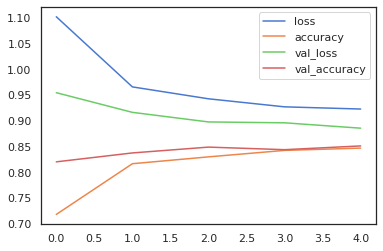

In [ ]:
pd.DataFrame(model5_hist.history).plot()

In [ ]:
model_5.evaluate(val_all_dataset)

945/945 [==============================] - 92s 97ms/step - loss: 0.8852 - accuracy: 0.8543


[0.8851575255393982, 0.8542963266372681]

In [ ]:
# Save it
model_5.save("skimlit_20k")

INFO:tensorflow:Assets written to: skimlit_20k/assets


INFO:tensorflow:Assets written to: skimlit_20k/assets


In [ ]:
from google.colab import files
files.download('skimlit_20k')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Scale up

We're doing the exact same thing but with 200k samples

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
train_data = pd.DataFrame(preprocess(filenames[2]))
test_data = pd.DataFrame(preprocess(filenames[0]))
val_data = pd.DataFrame(preprocess(filenames[1]))
train_data[:10]

,target,text,line,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


In [ ]:
len(test_data), len(train_data), len(val_data)

(29493, 2211861, 28932)

In [ ]:
oh = OneHotEncoder(sparse=False)
train_labels_oh = oh.fit_transform(train_data["target"].to_numpy().reshape(-1, 1))
test_labels_oh = oh.transform(test_data["target"].to_numpy().reshape(-1, 1))
val_labels_oh = oh.transform(val_data["target"].to_numpy().reshape(-1, 1))

In [ ]:
train_line_number_oh = tf.one_hot(train_data["line"],depth=20)
test_line_number_oh = tf.one_hot(test_data["line"],depth=20)
val_line_number_oh = tf.one_hot(val_data["line"],depth=20)
train_line_number_oh[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
train_line_total_oh = tf.one_hot(train_data["total_lines"],depth=20)
test_line_total_oh = tf.one_hot(test_data["total_lines"],depth=20)
val_line_total_oh = tf.one_hot(val_data["total_lines"],depth=20)

In [ ]:
train_chars = [split_char(sentence) for sentence in train_data["text"]]
val_chars = [split_char(sentence) for sentence in val_data["text"]]
test_chars = [split_char(sentence) for sentence in test_data["text"]]

In [ ]:
train_all_data = tf.data.Dataset.from_tensor_slices((train_data["text"],train_chars,train_line_number_oh,train_line_total_oh))
train_all_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh)
train_all_dataset = tf.data.Dataset.zip((train_all_data,train_all_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_all_data = tf.data.Dataset.from_tensor_slices((val_data["text"],val_chars,val_line_number_oh,val_line_total_oh))
val_all_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh)
val_all_dataset = tf.data.Dataset.zip((val_all_data,val_all_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_all_data = tf.data.Dataset.from_tensor_slices((test_data["text"],test_chars,test_line_number_oh,test_line_total_oh))
test_all_labels = tf.data.Dataset.from_tensor_slices(test_labels_oh)
test_all_dataset = tf.data.Dataset.zip((test_all_data,test_all_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_all_dataset

<PrefetchDataset shapes: (((None,), (None,), (None, 20), (None, 20)), (None, 5)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>

In [ ]:
# Build a thribrid model

# Token model
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_inputs")
token_emb = hub_emb_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_emb)
token_model = tf.keras.Model(token_inputs,token_outputs)

# Char model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vec = char_vectorizer(char_inputs)
char_em = char_emb(char_vec)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_em)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

# Concatenate
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
z = layers.Dense(256,activation="relu")(token_char_concat)
z = layers.Dropout(0.5)(z)

# Line number model
line_number_inputs = layers.Input(shape=(20,),dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,x)

# Total line model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32, name="total_line_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,y)

# Concatenate
tribrid_emb = layers.Concatenate(name="tribrid_emb")([z,
                                                      line_number_model.output,
                                                      total_lines_model.output])

# Output layers
a = layers.Dense(128,activation="relu")(tribrid_emb)
a = layers.Dropout(0.5)(a)
output_layer = layers.Dense(5,activation="softmax",name="output_layer")(a)

final_model = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_number_model.input,
                                 total_lines_model.input],
                         outputs=output_layer)

In [ ]:
final_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="Adam",
                metrics="accuracy")

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [ ]:
final_model.fit(train_all_dataset,
                          epochs=100,
                          steps_per_epoch= int(0.01*len(train_all_dataset)),
                          validation_data=val_all_dataset,
                          validation_steps= int(0.01*len(val_all_dataset)),
                          callbacks=[callback])

Epoch 1/100
691/691 [==============================] - 143s 207ms/step - loss: 1.0447 - accuracy: 0.7616 - val_loss: 0.9232 - val_accuracy: 0.8264
Epoch 2/100
691/691 [==============================] - 153s 222ms/step - loss: 0.9551 - accuracy: 0.8209 - val_loss: 0.8764 - val_accuracy: 0.8507
Epoch 3/100
691/691 [==============================] - 151s 218ms/step - loss: 0.9341 - accuracy: 0.8365 - val_loss: 0.8724 - val_accuracy: 0.8819
Epoch 4/100
691/691 [==============================] - 168s 243ms/step - loss: 0.9169 - accuracy: 0.8417 - val_loss: 0.8632 - val_accuracy: 0.8715
Epoch 5/100
691/691 [==============================] - 145s 209ms/step - loss: 0.9155 - accuracy: 0.8456 - val_loss: 0.8480 - val_accuracy: 0.8715
Epoch 6/100
691/691 [==============================] - 149s 215ms/step - loss: 0.9091 - accuracy: 0.8507 - val_loss: 0.8420 - val_accuracy: 0.8819
Epoch 7/100
691/691 [==============================] - 137s 198ms/step - loss: 0.9034 - accuracy: 0.8564 - val_loss: 0

In [ ]:
final_model.save("/content/drive/MyDrive/test tf/nlp/final_model_200.h5",save_format='tf')

NotImplementedError: ignored

In [ ]:
!tensorflowjs_converter --input_format=keras "/content/drive/MyDrive/testtf/nlp/final_model_200.h5" "/content/drive/MyDrive/testtf/nlp/js"

tcmalloc: large alloc 1277771776 bytes == 0x56143b078000 @  0x7fae55a49615 0x5613f4e484cc 0x5613f4f2847a 0x5613f4f60793 0x5613f4e4c3ce 0x5613f4e4e698 0x5613f4fc6f5a 0x5613f4f293b2 0x5613f4e4b2ed 0x5613f4f3ce1d 0x5613f4ebee99 0x5613f4e4cafa 0x5613f4eba915 0x5613f4eb9ced 0x5613f4e4cbda 0x5613f4ebb737 0x5613f4eb99ee 0x5613f4e4cbda 0x5613f4ebb737 0x5613f4eb99ee 0x5613f4e4cbda 0x5613f4ebb737 0x5613f4e4cafa 0x5613f4eba915 0x5613f4e4cafa 0x5613f4eba915 0x5613f4e4cafa 0x5613f4eba915 0x5613f4e4cafa 0x5613f4eba915 0x5613f4eb99ee


In [ ]:
!ls /content/drive/MyDrive/testtf/nlp/js

group1-shard100of246.bin  group1-shard176of246.bin  group1-shard28of246.bin
group1-shard101of246.bin  group1-shard177of246.bin  group1-shard29of246.bin
group1-shard102of246.bin  group1-shard178of246.bin  group1-shard2of246.bin
group1-shard103of246.bin  group1-shard179of246.bin  group1-shard30of246.bin
group1-shard104of246.bin  group1-shard17of246.bin   group1-shard31of246.bin
group1-shard105of246.bin  group1-shard180of246.bin  group1-shard32of246.bin
group1-shard106of246.bin  group1-shard181of246.bin  group1-shard33of246.bin
group1-shard107of246.bin  group1-shard182of246.bin  group1-shard34of246.bin
group1-shard108of246.bin  group1-shard183of246.bin  group1-shard35of246.bin
group1-shard109of246.bin  group1-shard184of246.bin  group1-shard36of246.bin
group1-shard10of246.bin   group1-shard185of246.bin  group1-shard37of246.bin
group1-shard110of246.bin  group1-shard186of246.bin  group1-shard38of246.bin
group1-shard111of246.bin  group1-shard187of246.bin  group1-shard39of246.bin
group1-shard1

In [ ]:
!zip -r /content/drive/MyDrive/testtf/nlp/js.zip /content/drive/MyDrive/testtf/nlp/js 

updating: content/drive/MyDrive/testtf/nlp/js/ (stored 0%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard1of246.bin (deflated 7%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard2of246.bin (deflated 7%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard3of246.bin (deflated 7%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard4of246.bin (deflated 7%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard5of246.bin (deflated 7%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard6of246.bin (deflated 7%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard7of246.bin (deflated 7%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard8of246.bin (deflated 7%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard9of246.bin (deflated 7%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard10of246.bin (deflated 7%)
  adding: content/drive/MyDrive/testtf/nlp/js/group1-shard11of246.bin (deflated 7%)
  adding: content/drive/My

In [ ]:
final_model.evaluate(test_all_dataset)

In [ ]:
import tensorflow as tf 
final_model = tf.keras.models.load_model("/content/drive/MyDrive/test tf/nlp/final_model_200.h5")
final_model.summary()